In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import panel as pn
import param
import glob
pn.extension()

In [30]:
import os

In [31]:
def get_map(da,sgmap=None):
    if not sgmap:
        sgmap=xr.open_dataset('sgmap.nc')
    return da.sel(gridcell=sgmap.cclass).where(sgmap.notnan).compute()



In [32]:
def amean(da,cf=1/365):
    dpm=da['time.daysinmonth']
    x=cf*(dpm*da).groupby('time.year').sum()
    return x.compute()

In [33]:
def gmean(da,la,cf=None):
    if not cf:
        cf=1/la.sum()
    x=cf*(la*da).sum(dim=['lat','lon'])
    return x.compute()

### Figure 1

In [20]:
df=pd.read_csv('cats.csv')
cats=['Hydrology','Biophysics','Stomatal Conductance &\nPhotosynthesis','Biogeochemistry','Fire',]
subs=np.unique(df.subcat.values)

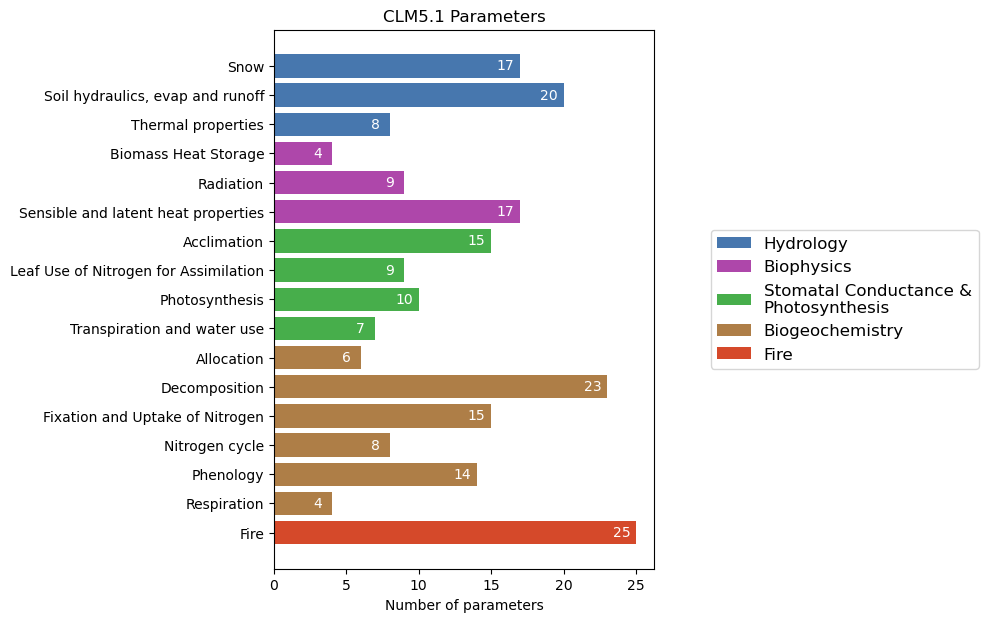

In [24]:
fig = plt.figure(figsize=[9,7])
axs = fig.subplot_mosaic('AX;AB;AY',gridspec_kw={'height_ratios': [1,4,1],'width_ratios': [3, 2]})

i=16
xlabs=[]
for cat in cats:
    cts=[]
    subs=np.unique(df.subcat[df.cat==cat].values)
    for sub in subs:
        xlabs.append(sub)
        cts.append((df.subcat==sub).sum())
    axs['A'].barh(i-np.arange(len(cts)),cts,facecolor=df.color[df.cat==cat].values[0],alpha=1)
    axs['B'].barh(i+np.arange(len(cts)),cts,facecolor=df.color[df.cat==cat].values[0],alpha=1,label=cat)
    
    for j,ct,sub in zip(i-np.arange(len(cts)),cts,subs):
        c=df.color[df.subcat==sub].values[0]
        axs['A'].text(ct-1,j,ct,ha='center',va='center',color='w')
        
    i-=len(cts)

axs['A'].set_yticks(range(17));
axs['A'].set_yticklabels(np.flip(xlabs));
axs['A'].set_xlabel('Number of parameters')
axs['A'].set_title('CLM5.1 Parameters');

axs['B'].set_xlim([-10,-9])
axs['B'].legend(fontsize=12,loc=10)

axs['B'].set_axis_off()
axs['X'].set_axis_off()
axs['Y'].set_axis_off()

plt.savefig('../figs/main/bar.png',bbox_inches='tight');

### Figure 1

In [200]:
#locate the history files and read in the dataset
d='/glade/p/cgd/tss/people/oleson/clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_nocrop_PPE2_hist/lnd/hist/'
tape='h0'
files = sorted(glob.glob(d+'*.'+tape+'.*'))
yrs=np.array([int(f.split('.'+tape+'.')[1][:4]) for f in files])
yr0=1985
files = np.array(files)[yrs>=yr0]
def preprocess(ds):
    dvs=['TLAI','GPP','ER','SOILWATER_10CM','EFLX_LH_TOT','TV']
    return ds[dvs]
ds = xr.open_mfdataset(files,combine='nested',concat_dim='time',
                       decode_times=False,preprocess=preprocess)
ds['time']=xr.cftime_range(str(yr0),periods=len(ds.time),freq='MS',calendar='noleap')

In [201]:
#locate the sparsegrids and read in the fullgrid landarea
d='/glade/u/home/forrest/ppe_representativeness/output_v4/'
files=np.array(glob.glob(d+'*annual+sd*'))
ix=np.argsort(np.array([f.split('.')[-2] for f in files]).astype(int))
files=files[ix]
tmp=xr.open_dataset(files[0])
la=tmp.area*tmp.landfrac

In [202]:
#function to compute global GPP from a given sparsegrid subsample
def get_gpp(file,gpp):
    sg=xr.open_dataset(file)
    xv=np.zeros([gpp.shape[0],len(sg.numclust)+1])+np.nan
    ix=sg.rcent.values[sg.rcent>0].astype(int)
    xv[:,ix]=gpp[:,sg.rcent>0]
    c=sg.cclass.values.ravel()
    c=c[c>0].astype(int)
    mapped=np.zeros(gpp.shape)+np.nan
    mapped[:,sg.cclass>0]=xv[:,c]
    out=xr.DataArray(mapped,dims=['year','lat','lon'])
    gppsg=gmean(out,la)
    return gppsg

Text(0.5, 0.9, 'Title')

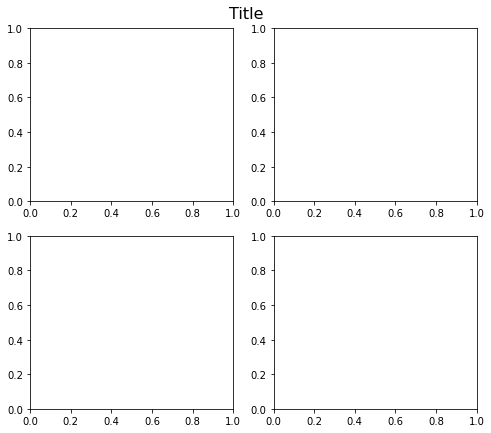

In [223]:
fig=plt.figure(figsize=[8,7])
for i in range(4):
    plt.subplot(2,2,i+1)
fig.text(0.5,0.9,'Title',fontsize=16,ha='center')

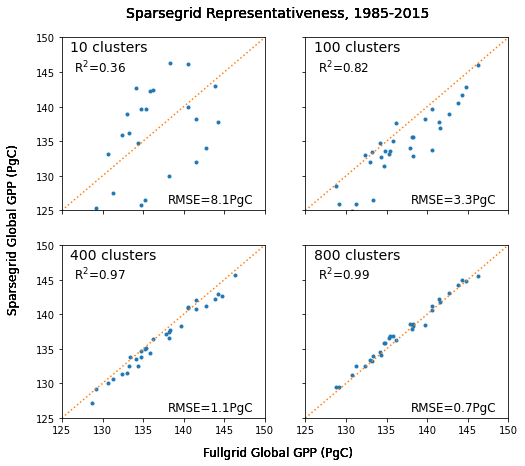

In [229]:
#final plot
gpp=amean(ds.GPP,cf=24*60*60)
gppfg=gmean(gpp,la,cf=1e-9)
fig=plt.figure(figsize=[8,7])

for i,file in enumerate(files[[0,5,10,-1]]):

    gppsg=la.sum()*1e-9*get_gpp(file,gpp.values)

    plt.subplot(2,2,i+1)
    plt.plot(gppfg,gppsg,'.')
    plt.plot([125,150],[125,150],':')
    plt.xlim([125,150])
    plt.ylim([125,150])
    c=file.split('.')[-2]
    
    
    rmse=str(np.round(np.sqrt(np.mean((gppfg-gppsg)**2)).values,1))
    r2=str(np.round(np.corrcoef(gppfg,gppsg)[0,1]**2,2))
    
    plt.text(126,148,c+' clusters',fontsize=14)
    #if i>0:
    #    plt.text(126.5,142.6,r'RMSE='+rmse+'PgC',fontsize=12)
    #else:
    plt.text(138,126,r'RMSE='+rmse+'PgC',fontsize=12)
    plt.text(126.5,145,r'R$^2$='+r2,fontsize=12)
    
    
    if (i%2)>0:
        plt.yticks(range(125,155,5),'')
        
    if i<2:
        plt.xticks(range(125,155,5),'')
        
        
    #if i==12:
    #    plt.xlabel('Fullgrid Global GPP (PgC)',fontsize=20)
        
    #if i==5:
    #    
    
    fig.text(0.5,0.92,'Sparsegrid Representativeness, 1985-2015',fontsize=14,ha='center')
    fig.text(0.03,0.5,'Sparsegrid Global GPP (PgC)',rotation='vertical',va='center',fontsize=12)
    fig.text(0.5,0.05,'Fullgrid Global GPP (PgC)',ha='center',fontsize=12)
plt.savefig('../figs/sparsegrid_gpp.pdf',bbox_inches='tight')

In [209]:
#final plot
gpp=amean(ds.GPP,cf=24*60*60)
gppfg=gmean(gpp,la,cf=1e-9)
plt.figure(figsize=[20,9])

for i,file in enumerate(files):

    gppsg=la.sum()*1e-9*get_gpp(file,gpp.values)

    plt.subplot(3,5,i+1)
    plt.plot(gppfg,gppsg,'.')
    plt.plot([125,150],[125,150],':')
    plt.xlim([125,150])
    plt.ylim([125,150])
    c=file.split('.')[-2]
    
    
    rmse=str(np.round(np.sqrt(np.mean((gppfg-gppsg)**2)).values,1))
    r2=str(np.round(np.corrcoef(gppfg,gppsg)[0,1]**2,2))
    
    plt.text(126,148,c+' clusters',fontsize=14)
    if i>0:
        plt.text(126.5,142.6,r'RMSE='+rmse+'PgC',fontsize=12)
    else:
        plt.text(138,126,r'RMSE='+rmse+'PgC',fontsize=12)
    plt.text(126.5,145,r'R$^2$='+r2,fontsize=12)
    
    
    if (i%5)>0:
        plt.yticks(range(125,155,5),'')
        
    if i<10:
        plt.xticks(range(125,155,5),'')
        
        
    if i==12:
        plt.xlabel('Fullgrid Global GPP (PgC)',fontsize=20)
        
    if i==5:
        plt.ylabel('Sparsegrid Global GPP (PgC)',fontsize=20)
    
    if i==2:
        plt.title('Sparsegrid Representativeness, 1985-2015',fontsize=20)
        
plt.savefig('../supp/sparsegrid_full.pdf',bbox_inches='tight')

### Figure 2

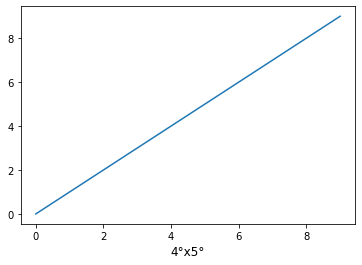

In [22]:
plt.plot(range(10))
plt.xlabel(u'4\N{DEGREE SIGN}x5\N{DEGREE SIGN}',fontsize=12);

In [34]:
npix={}
d=u'\N{DEGREE SIGN}'
npix['1'+d]=22648
npix['2'+d]=5666
npix['4'+d+'x5'+d]=1764
npix['sg']=400
def sims(ny,npix):
    if ny=='Mtrx':
        ny=140
    sg=400
    pecost=5
    s=t/((ny+10)*npix/sg*pecost)
    if s<10:
        s=np.round(s,1)
    else:
        s=int(np.round(s))
    return s

In [35]:
t=1e6
pecost=5
nys=[1500,1500,1500,'Mtrx','Mtrx','Mtrx',1500,'Mtrx']
gs =['1'+d,'2'+d,'4'+d+'x5'+d,'1'+d,'2'+d,'4'+d+'x5'+d,'sg','sg']
svals={}
for ny,g in zip(nys,gs):
    x = "yrs" if ny==1500 else ""
    k=str(ny)+x+'-'+g
    svals[k]=sims(ny,npix[g])

In [36]:
ds=xr.open_dataset('clusters.clm51_PPEn02ctsm51d021_2deg_GSWP3V1_leafbiomassesai_PPE3_hist.annual+sd.400.nc')
lons=xr.DataArray([c[0] for c in ds.rcent_coords.values],dims='lon')
lats=xr.DataArray([c[1] for c in ds.rcent_coords.values],coords=[lons])

In [37]:
import warnings
warnings.filterwarnings("ignore")

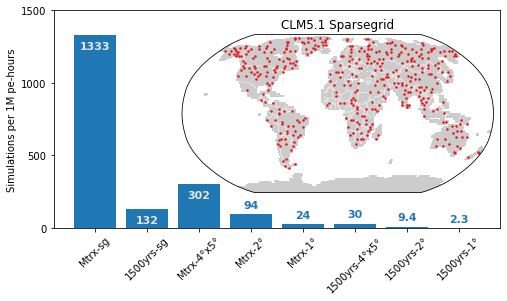

In [40]:
fig=plt.figure(figsize=[8,4])
ax0=fig.add_subplot(111)
x=np.flip([m for m in svals])
y=[svals[m] for m in x]
ax0.bar(x,y)
ax0.set_xticklabels(x,rotation=45)
ax0.set_ylabel('Simulations per 1M pe-hours')
ax0.set_ylim([0,1500]);
ax0.set_yticks(500*np.arange(4))

for i in range(3):
    c=0.9*np.ones(3)
    plt.text(i,y[i]-100,y[i],ha='center',color=c,fontsize=11,fontweight='bold')
    
for i in range(3,8):
    c='C0'
    plt.text(i,y[i]+40,y[i],ha='center',color=c,fontsize=11,fontweight='bold')


axs = fig.subplot_mosaic('AA;XB;CC',gridspec_kw={'height_ratios': [0.5,7, 1],'width_ratios': [1, 4]},
                             subplot_kw={'projection': ccrs.Robinson()})
axs['A'].set_axis_off()
axs['C'].set_axis_off()
axs['X'].set_axis_off()

ax=axs['B']
cmap=ListedColormap(0.8*np.ones(3))
x=ds.landfrac_orig>0
mappable = x.where(x).plot(transform=ccrs.PlateCarree(),ax=ax,add_colorbar=False,cmap=cmap)
lats.plot.line('.',transform=ccrs.PlateCarree(),ax=ax,color=[0.9,0.1,0.1],ms=3,label='sparsegrid')
ax.set_title('CLM5.1 Sparsegrid')
transform = ccrs.PlateCarree()._as_mpl_transform(ax)
ax.add_feature(cfeature.BORDERS,edgecolor=[0.9,0.9,0.9]);
plt.savefig('../figs/sims.pdf',bbox_inches='tight')

In [323]:
f='/glade/u/home/djk2120/ppe_clean/postp/OAAT_surv.nc'
ds=xr.open_dataset(f)

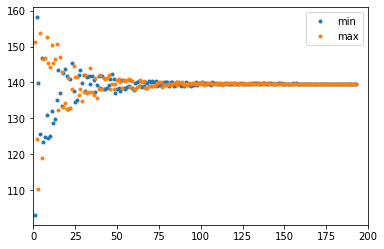

In [347]:
da=ds.GPP_global_mean.sel(exp='CTL2010')
xdef=da.sel(param='default',minmax='min')
da=da.isel(param=1+np.arange(193))
dx1=abs(da.sel(minmax='max')-da.sel(minmax='min'))
dx2=abs(da.sel(minmax='max')-xdef)
dx3=abs(da.sel(minmax='min')-xdef)
dx=xr.DataArray(np.max([dx1,dx2,dx3],axis=0),dims='param')
plt.plot(1+np.arange(193),da.sortby(dx,ascending=False),'.')
plt.legend(da.minmax.values)
plt.xlim([0,200]);

### Figure 4

In [12]:
f='/glade/u/home/djk2120/ppe_clean/postp/OAAT_surv.nc'
ds=xr.open_dataset(f)

In [13]:
exps=['CTL2010','C285','C867','AF1855','AF2095','NDEP']

In [14]:
expkey={'CTL2010':'Control',
        'C285':r'-CO$_2$',
        'C867':r'+CO$_2$',
        'AF1855':'PI \nClimate',
        'AF2095':'Future \nClimate',
        'NDEP':'+NDEP'}
exps=['CTL2010','C285','C867','AF1855','AF2095','NDEP']
expnames=[expkey[exp] for exp in exps]

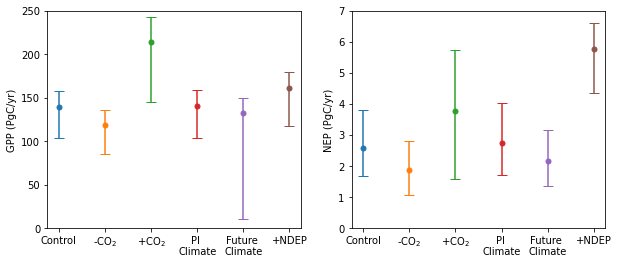

In [15]:
fig,(ax1,ax2)=plt.subplots(ncols=2,figsize=[10,4])
for v,ax in zip(['GPP','NEP'],[ax1,ax2]):
    for i,exp in enumerate(exps):
        da=ds[v+'_global_mean'].sel(exp=exp)
        xdef=da.sel(param='default',minmax='min')
        err=np.array([xdef-da.min(),da.max()-xdef]).reshape([-1,1])
        ax.errorbar([i],[xdef],err,fmt='o',ms=5,capsize=5)
    ax.set_xticks(range(6))
    ax.set_xticklabels([expkey[exp] for exp in exps])
    ax.set_ylabel(v+' (PgC/yr)')
        
ax1.set_ylim([0,250])
ax2.set_ylim([0,7])
plt.savefig('../figs/ranges.png',dpi=300,bbox_inches='tight');

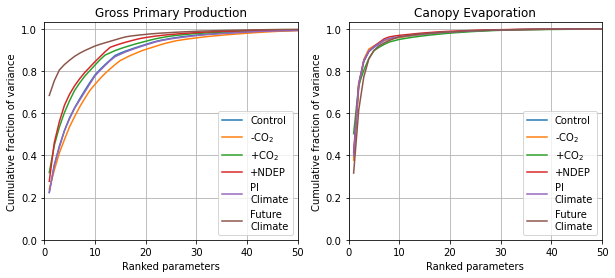

In [36]:
plt.figure(figsize=[10,4])
lns={'FCEV':'Canopy Evaporation','GPP':'Gross Primary Production'}
for i,dv in enumerate(['GPP','FCEV']):
    plt.subplot(1,2,i+1)
    da=ds[dv+'_global_mean']
    xdef=da.sel(param='default',minmax='min')
    v=((da-xdef)**2).sum(dim='minmax')

    for exp in da.exp.values:
        vn=v.sel(exp=exp)/v.sel(exp=exp).sum()
        plt.plot(range(1,195),
                 np.flip(np.sort(vn)).cumsum(),
                 label=expkey[exp])
    plt.legend()
    plt.xlim([0,50])
    plt.ylim([0,1.03])
    plt.grid()
    plt.xlabel('Ranked parameters')
    plt.ylabel('Cumulative fraction of variance')
    plt.title(lns[dv]);
plt.savefig('../figs/variance.pdf',bbox_inches='tight');

In [42]:
dv='FCEV'
da=ds[dv+'_global_mean']
xdef=da.sel(param='default',minmax='min')
v=((da-xdef)**2).sum(dim='minmax')

In [47]:
params=['cv', 'dleaf', 'maximum_leaf_wetted_fraction','liq_canopy_storage_scalar']

In [51]:
v.sel(param=params).sum(dim='param')/v.sum(dim='param')

<xarray.DataArray 'FCEV_global_mean' (exp: 6)>
array([0.89194841, 0.90371106, 0.83976264, 0.89297066, 0.89467199,
       0.73939959])
Coordinates:
    group    <U6 'global'
  * exp      (exp) object 'CTL2010' 'C285' 'C867' 'NDEP' 'AF1855' 'AF2095'

In [35]:
dv='GPP'
da=ds[dv+'_global_mean']
xdef=da.sel(param='default',minmax='min')
v=((da-xdef)**2).sum(dim='minmax')
avg=0
for exp in exps:
    vn=v.sel(exp=exp)/v.sel(exp=exp).sum()
    b=np.flip(np.sort(vn)).cumsum()[9]
    print(exp,b)

CTL2010 0.7802953118519078
C285 0.7359700312135905
C867 0.8274656980213829
AF1855 0.7759535310331829
AF2095 0.9177543097303938
NDEP 0.843274554739454


In [27]:
avg

0.963248054347855

### Figure 5

In [98]:
def rank_plot(da,nx,ax=None):
    df=pd.read_csv('cats.csv')
    x = top_n(da,nx)
    xdef = da.sel(param='default',minmax='min')

    if not ax:
        fig=plt.figure()
        ax=fig.add_subplot()

    ax.plot([xdef,xdef],[0,nx-1],'k:',label='default')

    i=-1
    for xmin,xmax in x:
        i+=1
        c=df.color[df.param==xmin.param].values[0]
        ax.plot([xmin,xmax],[i,i],color=c,lw=2)
        ax.plot(xmin,i,'o',color=c,fillstyle='none')
        ax.plot(xmax,i,'o',color=c)
    ax.set_yticks(range(nx))
    ax.set_yticklabels([p[:15] for p in x.param.values]);

In [99]:
def top_n(da,nx):
    ''' return top_n by param effect '''
    xdef=da.sel(param='default',minmax='min')
    dx1=abs(da.sel(minmax='max')-da.sel(minmax='min'))
    dx2=abs(da.sel(minmax='max')-xdef)
    dx3=abs(da.sel(minmax='min')-xdef)
    ix=np.argsort(np.max([dx1,dx2,dx3],axis=0))[-nx:]
    x=da.isel(param=ix)
    return x

In [100]:
f='/glade/u/home/djk2120/ppe_clean/postp/OAAT_surv.nc'
ds=xr.open_dataset(f)

In [103]:
df=pd.read_csv('cats.csv')

In [104]:
cats=np.unique(df.cat.values)
cols={cat:df.color[df.cat==cat].values[0] for cat in cats}

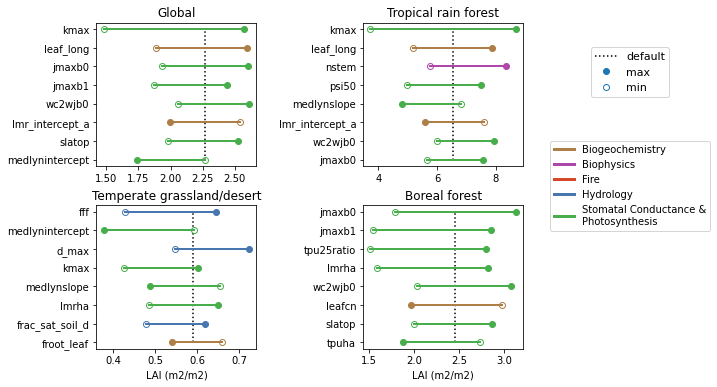

In [105]:
fig,axs=plt.subplot_mosaic('AXBF;AXBE;GXHE;CXDE;CXDI',
                           figsize=[11,6],
                           gridspec_kw={'width_ratios': [3,1,3,3],'height_ratios': [3, 1,0.5,1,3]})


for s in 'XEFGHI':
    axs[s].axis('off')


da=ds.TLAI_global_mean.sel(exp='CTL2010')
rank_plot(da,8,ax=axs['A'])
axs['A'].set_title('Global')

for b,s in zip([1,7,8],'BCD'):
    da=ds.TLAI_biome_mean.sel(exp='CTL2010',biome=b)
    rank_plot(da,8,ax=axs[s])
    axs[s].set_title(ds.biome_name[b].values)
    if b>1:
        axs[s].set_xlabel('LAI (m2/m2)')

        
axs['F'].plot([1,1],[1,1],'k:',label='default')
axs['F'].plot([1,1],[1,1],'C0o',label='max')
axs['F'].plot([1,1],[1,1],'C0o',label='min',fillstyle='none')
axs['F'].set_ylim([100,101])
axs['F'].legend(fontsize=11,loc=10)


for cat in cats:
    axs['E'].plot([1,1],[1,1],lw=3,color=cols[cat],label=cat)
axs['E'].legend(loc=10)

plt.savefig('../figs/lai_biome.pdf',bbox_inches='tight')

### Figure 6

In [185]:
df=pd.read_csv('cats.csv')
cats=np.unique(df.cat.values)

In [186]:
x=ds.EFLX_LH_TOT_global_mean
xd=x.sel(param='default',minmax='min',exp='CTL2010')
x[:,ds.param=='csol_sand',:]=xd
dx=x.sel(exp='AF2095')/x.sel(exp='CTL2010')
dx[ds.param=='csol_sand',:]=1.088

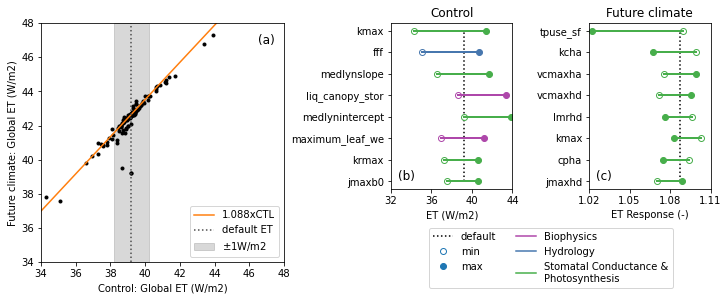

In [204]:
fig,axs=plt.subplot_mosaic('AFBHC;AFGGG;AFDDD;EEDDD',
                           figsize=[12,5],
                           gridspec_kw={'width_ratios': [4,1,2,0.5,2],'height_ratios': [4,0.2,1,0.5]})

for a in 'DEFGH':
    axs[a].axis('off')


ax=axs['A']
ax.plot(x.sel(exp='CTL2010'),x.sel(exp='AF2095'),'k.')
xx=np.array([34,48])
etp=np.round(dx.sel(param='default',minmax='min').values,3)
ax.plot(xx,etp*xx,'-C1',label=str(etp)+'xCTL')
ax.set_xlim(xx)
ax.set_ylim(xx)
ax.set_xlabel('Control: Global ET (W/m2)')
ax.set_ylabel('Future climate: Global ET (W/m2)')
ax.plot([xd,xd],[34,48],':',color=0.3*np.ones(3),label='default ET')
ax.fill_between([xd-1,xd+1],[34,34],[48,48],color=0.5*np.ones(3),alpha=0.3,label=r'$\pm$1W/m2')
ax.legend(loc=4)
ax.text(47,47,'(a)',fontsize=12,ha='center',va='center')

ax=axs['B']
rank_plot(x.sel(exp='CTL2010'),8,ax=ax)
ax.set_xlim([32,44])
ax.set_xticks(32+4*np.arange(4))
ax.set_xlabel('ET (W/m2)')
ax.set_title('Control')
ax.text(33.5,0.25,'(b)',fontsize=12,ha='center',va='center')


ax=axs['C']
rank_plot(dx,8,ax=ax)
ax.set_xlim([1.02,1.11])
ax.set_xticks(1.02+0.03*np.arange(4))
ax.set_xlabel('ET Response (-)')
ax.set_title('Future climate');
ax.text(1.02+0.09/8,0.25,'(c)',fontsize=12,ha='center',va='center')


ax=axs['D']
ax.plot([1,1],[1,1],'k:',label='default')
ax.plot(1,2,'C0o',fillstyle='none',label='min')
ax.plot(1,2,'C0o',label='max')

for cat in cats[[1,3,4]]:
    ax.plot([1,1],[1,1],color=df.color[df.cat==cat].values[0],label=cat)


ax.set_xlim([-99,-98])
ax.legend(loc=10,ncol=2)


plt.savefig('../figs/ET_response.png',bbox_inches='tight')

array(['Biophysics', 'Hydrology',
       'Stomatal Conductance &\nPhotosynthesis'], dtype=object)

In [141]:
help(plt.legend)

Help on function legend in module matplotlib.pyplot:

legend(*args, **kwargs)
    Place a legend on the Axes.
    
    Call signatures::
    
        legend()
        legend(labels)
        legend(handles, labels)
    
    The call signatures correspond to these three different ways to use
    this method:
    
    **1. Automatic detection of elements to be shown in the legend**
    
    The elements to be added to the legend are automatically determined,
    when you do not pass in any extra arguments.
    
    In this case, the labels are taken from the artist. You can specify
    them either at artist creation or by calling the
    :meth:`~.Artist.set_label` method on the artist::
    
        ax.plot([1, 2, 3], label='Inline label')
        ax.legend()
    
    or::
    
        line, = ax.plot([1, 2, 3])
        line.set_label('Label via method')
        ax.legend()
    
    Specific lines can be excluded from the automatic legend element
    selection by defining a label starting

### parameter table

In [114]:
plist=np.unique(plist)
keys=[catdict[p] for p in plist]
data=[tuple([k,p]) for k,p in zip(keys,plist)]
result = sorted(data, key = lambda x: (x[0], x[1]))
plist=[r[1] for r in result]

In [130]:
pfile=xr.open_dataset('/glade/campaign/asp/djk2120/PPEn11/paramfiles/OAAT0000.nc')

<xarray.DataArray 'd_max' ()>
array(15.)
Attributes:
    long_name:  Dry surface layer parameter
    units:      mm

In [156]:
names={'frac_sat_soil_dsl_init':'Fraction of saturated soil at which DSL initiates',
       'maximum_leaf_wetted_fraction':'Maximum leaf wetted fraction',
       'wc2wjb0':'Baseline ratio of wc:wj',
       'lmr_intercept_atkin':'Intercept in the calculation of leaf maintenance respiration base rate',
       'jmaxb1':'Response of electron transport rate to light',
       'slatop':'Specific leaf area at top of canopy'
       'liq_canopy_storage_scalar':}

In [167]:
for p in plist:
    if p in names:
        ln=names[p]
    elif p in pfile.data_vars:
        ln=pfile[p].long_name
    ln=ln[0].capitalize()+ln[1:]
    print(p.replace('_','\_'),'&',ln,'&',catkey[catdict[p]],'\\\\')

d\_max & Dry surface layer parameter & Sensible, latent heat and momentum fluxes \\
frac\_sat\_soil\_dsl\_init & Fraction of saturated soil at which DSL initiates & Sensible, latent heat and momentum fluxes \\
fff & Decay factor for fractional saturated area & Hydrology \\
liq\_canopy\_storage\_scalar & Canopy-storage-of-liquid-water parameter & Hydrology \\
maximum\_leaf\_wetted\_fraction & Maximum leaf wetted fraction & Hydrology \\
medlynintercept & Medlyn intercept of conductance-photosynthesis relationship & Stomatal resistance and photosynthesis \\
medlynslope & Medlyn slope of conductance-photosynthesis relationship & Stomatal resistance and photosynthesis \\
tpu25ratio & Ratio of tpu25top to vcmax25top & Stomatal resistance and photosynthesis \\
jmaxb0 & Baseline proportion of nitrogen allocated for electron transport & Photosynthetic capacity (LUNA) \\
jmaxb1 & Response of electron transport rate to light & Photosynthetic capacity (LUNA) \\
slatop & Specific leaf area at top o

In [107]:
for p in np.unique(plist):
    print(p,catdict[p])

cpha r
d_max b
fff d
frac_sat_soil_dsl_init b
froot_leaf l
jmaxb0 g
jmaxb1 g
jmaxhd r
kcha r
kmax h
krmax h
leaf_long m
leafcn l
liq_canopy_storage_scalar d
lmr_intercept_atkin j
lmrha r
lmrhd r
maximum_leaf_wetted_fraction d
medlynintercept f
medlynslope f
nstem i
psi50 h
slatop g
tpu25ratio f
tpuha r
tpuse_sf r
vcmaxha r
vcmaxhd r
wc2wjb0 g


In [95]:
np.unique(plist)

array(['cpha', 'd_max', 'fff', 'frac_sat_soil_dsl_init', 'froot_leaf',
       'jmaxb0', 'jmaxb1', 'jmaxhd', 'kcha', 'kmax', 'krmax', 'leaf_long',
       'leafcn', 'liq_canopy_storage_scalar', 'lmr_intercept_atkin',
       'lmrha', 'lmrhd', 'maximum_leaf_wetted_fraction',
       'medlynintercept', 'medlynslope', 'nstem', 'psi50', 'slatop',
       'tpu25ratio', 'tpuha', 'tpuse_sf', 'vcmaxha', 'vcmaxhd', 'wc2wjb0'],
      dtype=object)